# CLIP

CLIP을 이용해 임의의 이미지-텍스트 인풋 간 유사도를 계산하고, zero shot 이미지 분류를 수행합니다.


In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-72mh3bno
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-72mh3bno
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.3.0+cu121


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
clip.clip

<module 'clip.clip' from '/usr/local/lib/python3.10/dist-packages/clip/clip.py'>

In [8]:
ViT = clip.load("ViT-B/32")
print(type(ViT))
print(len(ViT))

<class 'tuple'>
2


In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 30.4MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [9]:
type(preprocess)

torchvision.transforms.transforms.Compose

In [10]:
type(model)

clip.model.CLIP

# Image Preprocessing

`preprocess`는 이미지 변환을 처리하는 클래스입니다.

- **이미지 크기 조정 → 중앙 부분 자르기 → 텐서 변환 → 정규화**

의 과정을 거칩니다.

각각은 다음과 같은 하이퍼파라미터를 가집니다.

1. 이미지 크기 조정

  `Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)`
  - size (목표 크기: 224)
  - interpolation (보간 방법. bicubic은 높은 품질의 이미지 크기 조정을 제공)
  - max_size (크기의 최댓값으로, 가로세로 비율을 유지하며 크기를 조정: None)
  - antialias (작은 이미지를 크게 할 때 이미지 품질 향상: None)

2. 중앙 부분 자르기 `CenterCrop(size=(224, 224))`
  - 이미지를 주어진 크기로 중앙 부분을 잘라냄.

3. 텐서 변환 `ToTensor()`
  - 이미지를 파이토치 텐서로 변환.
  - 이미지는 보통 PIL 이미지 / numpy 배열로 표현되며, 이를 파이토치 텐서로 변환.
  - 선택한 방법은 픽셀값을 [0,1] 범위로 정규화.

4. 정규화

  `Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))`

  - 각 채널의 평균(mean)과 표준편차(std)를 사용해 정규화
  - 선택한 방법은 RGB 채널별 평균값과 표준편차를 이용해 각각 0과 1로 정규화함.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7f3a24ffb440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

case-insensitive tokenizer를 사용합니다. `clip.tokenize()`.

아웃풋은 77개 토큰으로 패딩됩니다.

In [12]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [13]:
clip.tokenize("It's a banana. I think it's gone.")

tensor([[49406,   585,   568,   320,  8922,   269,   328,  1331,   585,   568,
          3601,   269, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [14]:
clip.tokenize("한국어도 되나?")

tensor([[49406, 15197,   250, 31871,   255, 31625,   112, 31972,   482,   167,
           238,   246, 27252,   502,   286, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

8개의 예제 이미지와 그 설명을 모델에게 주고, 관련 특징들과의 유사도를 보겠습니다.

In [15]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 우선 영어로 해볼게요. skimage의 이미지를 가져와 그 텍스트 설명도 같이 사용합니다.
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [21]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

In [17]:
os.listdir(skimage.data_dir)

['astronaut.png',
 'motorcycle_right.png',
 'coffee.png',
 'page.png',
 'retina.jpg',
 'cell.png',
 'color.png',
 'chessboard_GRAY.png',
 'ihc.png',
 'phantom.png',
 'grass.png',
 'text.png',
 'motorcycle_disp.npz',
 'brick.png',
 'camera.png',
 'logo.png',
 'clock_motion.png',
 'horse.png',
 'moon.png',
 'lfw_subset.npy',
 'hubble_deep_field.jpg',
 'coins.png',
 'README.txt',
 'gravel.png',
 'lbpcascade_frontalface_opencv.xml',
 'chessboard_RGB.png',
 'motorcycle_left.png',
 'rocket.jpg',
 'chelsea.png',
 'microaneurysms.png']

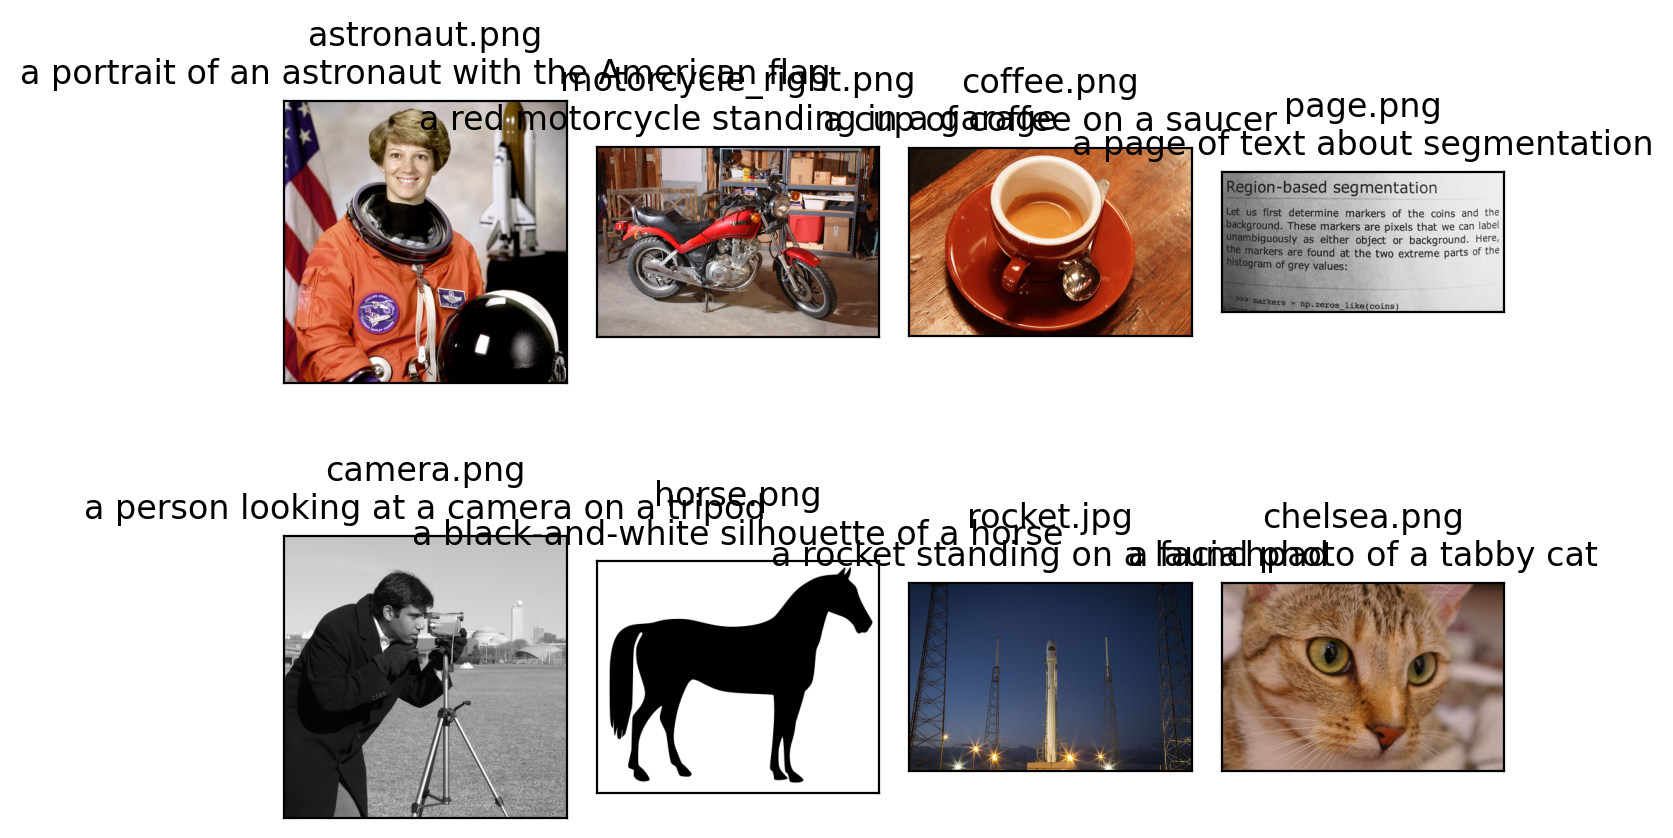

In [22]:
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


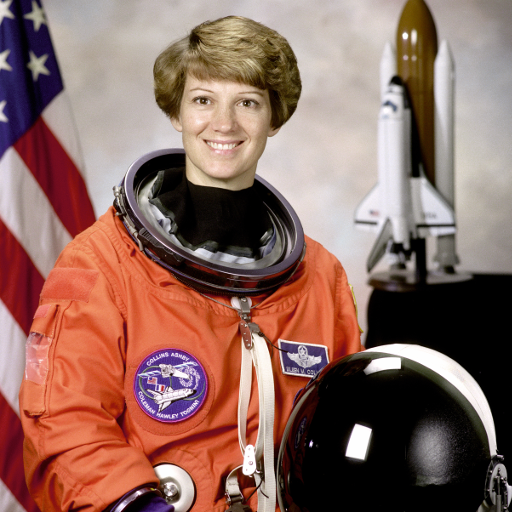

In [19]:
original_images[0]

In [23]:
texts[0]

'a portrait of an astronaut with the American flag'

## Building features

이미지를 정규화하고, 각 텍스트를 토크나이징 한 뒤 모델의 forward pass를 실행해 이미지와 텍스트의 특징을 뽑아봅시다.

In [24]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [25]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

각 이미지-텍스트 쌍의 내적으로 유사도를 구해보겠습니다.

In [26]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [27]:
similarity #8개 쌍에 대해 유사도가 나왔네요

array([[0.276764  , 0.15013461, 0.14953461, 0.12996227, 0.16582617,
        0.16265653, 0.22073916, 0.16811681],
       [0.15480246, 0.32057947, 0.12521824, 0.14272468, 0.11985052,
        0.16220488, 0.15933995, 0.15410961],
       [0.14814067, 0.12159108, 0.2930898 , 0.1437191 , 0.17419636,
        0.15400442, 0.12266819, 0.18379952],
       [0.14676848, 0.16312867, 0.19833222, 0.35391587, 0.20149976,
        0.20000333, 0.15956287, 0.20106556],
       [0.18585536, 0.1607168 , 0.13662991, 0.18864024, 0.30479845,
        0.19504192, 0.20692638, 0.20821352],
       [0.11462487, 0.16737938, 0.15417069, 0.1725612 , 0.21314073,
        0.34598106, 0.1487259 , 0.14569373],
       [0.19189939, 0.15816064, 0.13830814, 0.1741471 , 0.20163749,
        0.1698535 , 0.30291963, 0.17756954],
       [0.11960865, 0.12491632, 0.16607127, 0.1208591 , 0.1596784 ,
        0.15256464, 0.11878991, 0.30741104]], dtype=float32)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

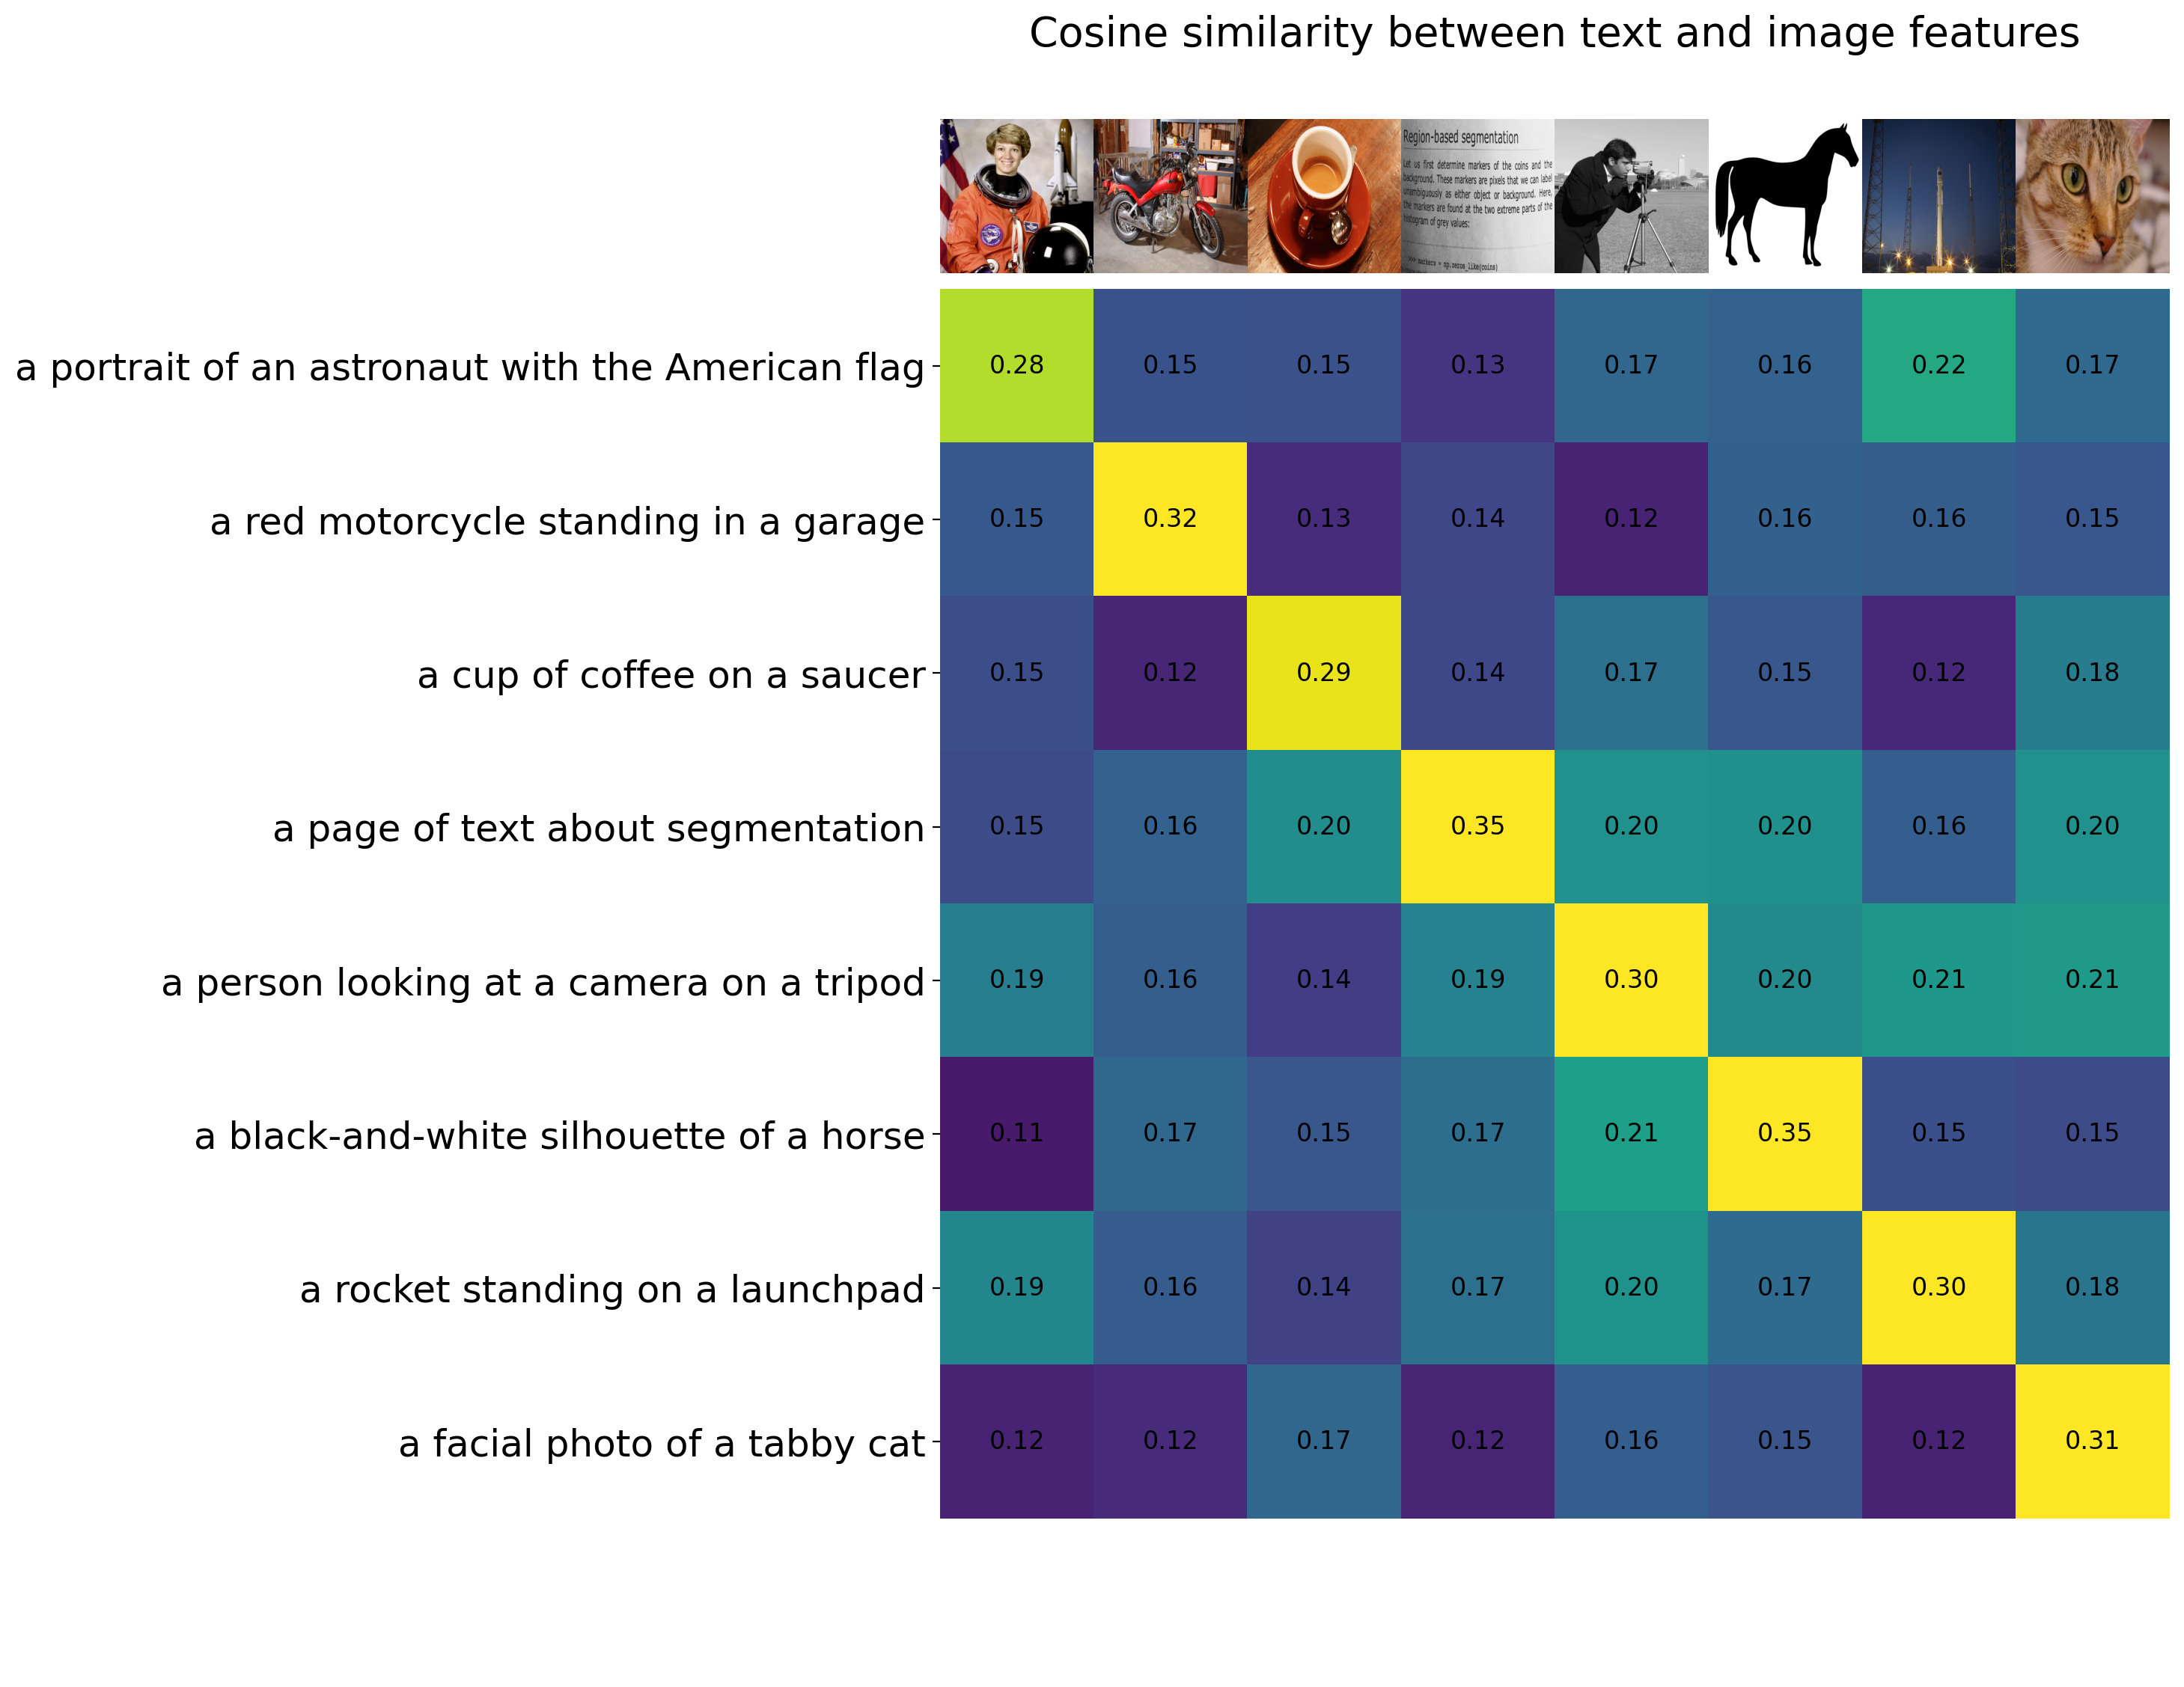

In [28]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)

plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

이미지를 분류할 때, softmax의 logit으로 코사인 유사도(*100)을 활용할 수 있습니다.


In [29]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:05<00:00, 29623405.97it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [33]:
cifar100.classes # 분류된 객체 간 차이가 반영되지 않은 단순한 클래스 분류

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

In [34]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [35]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

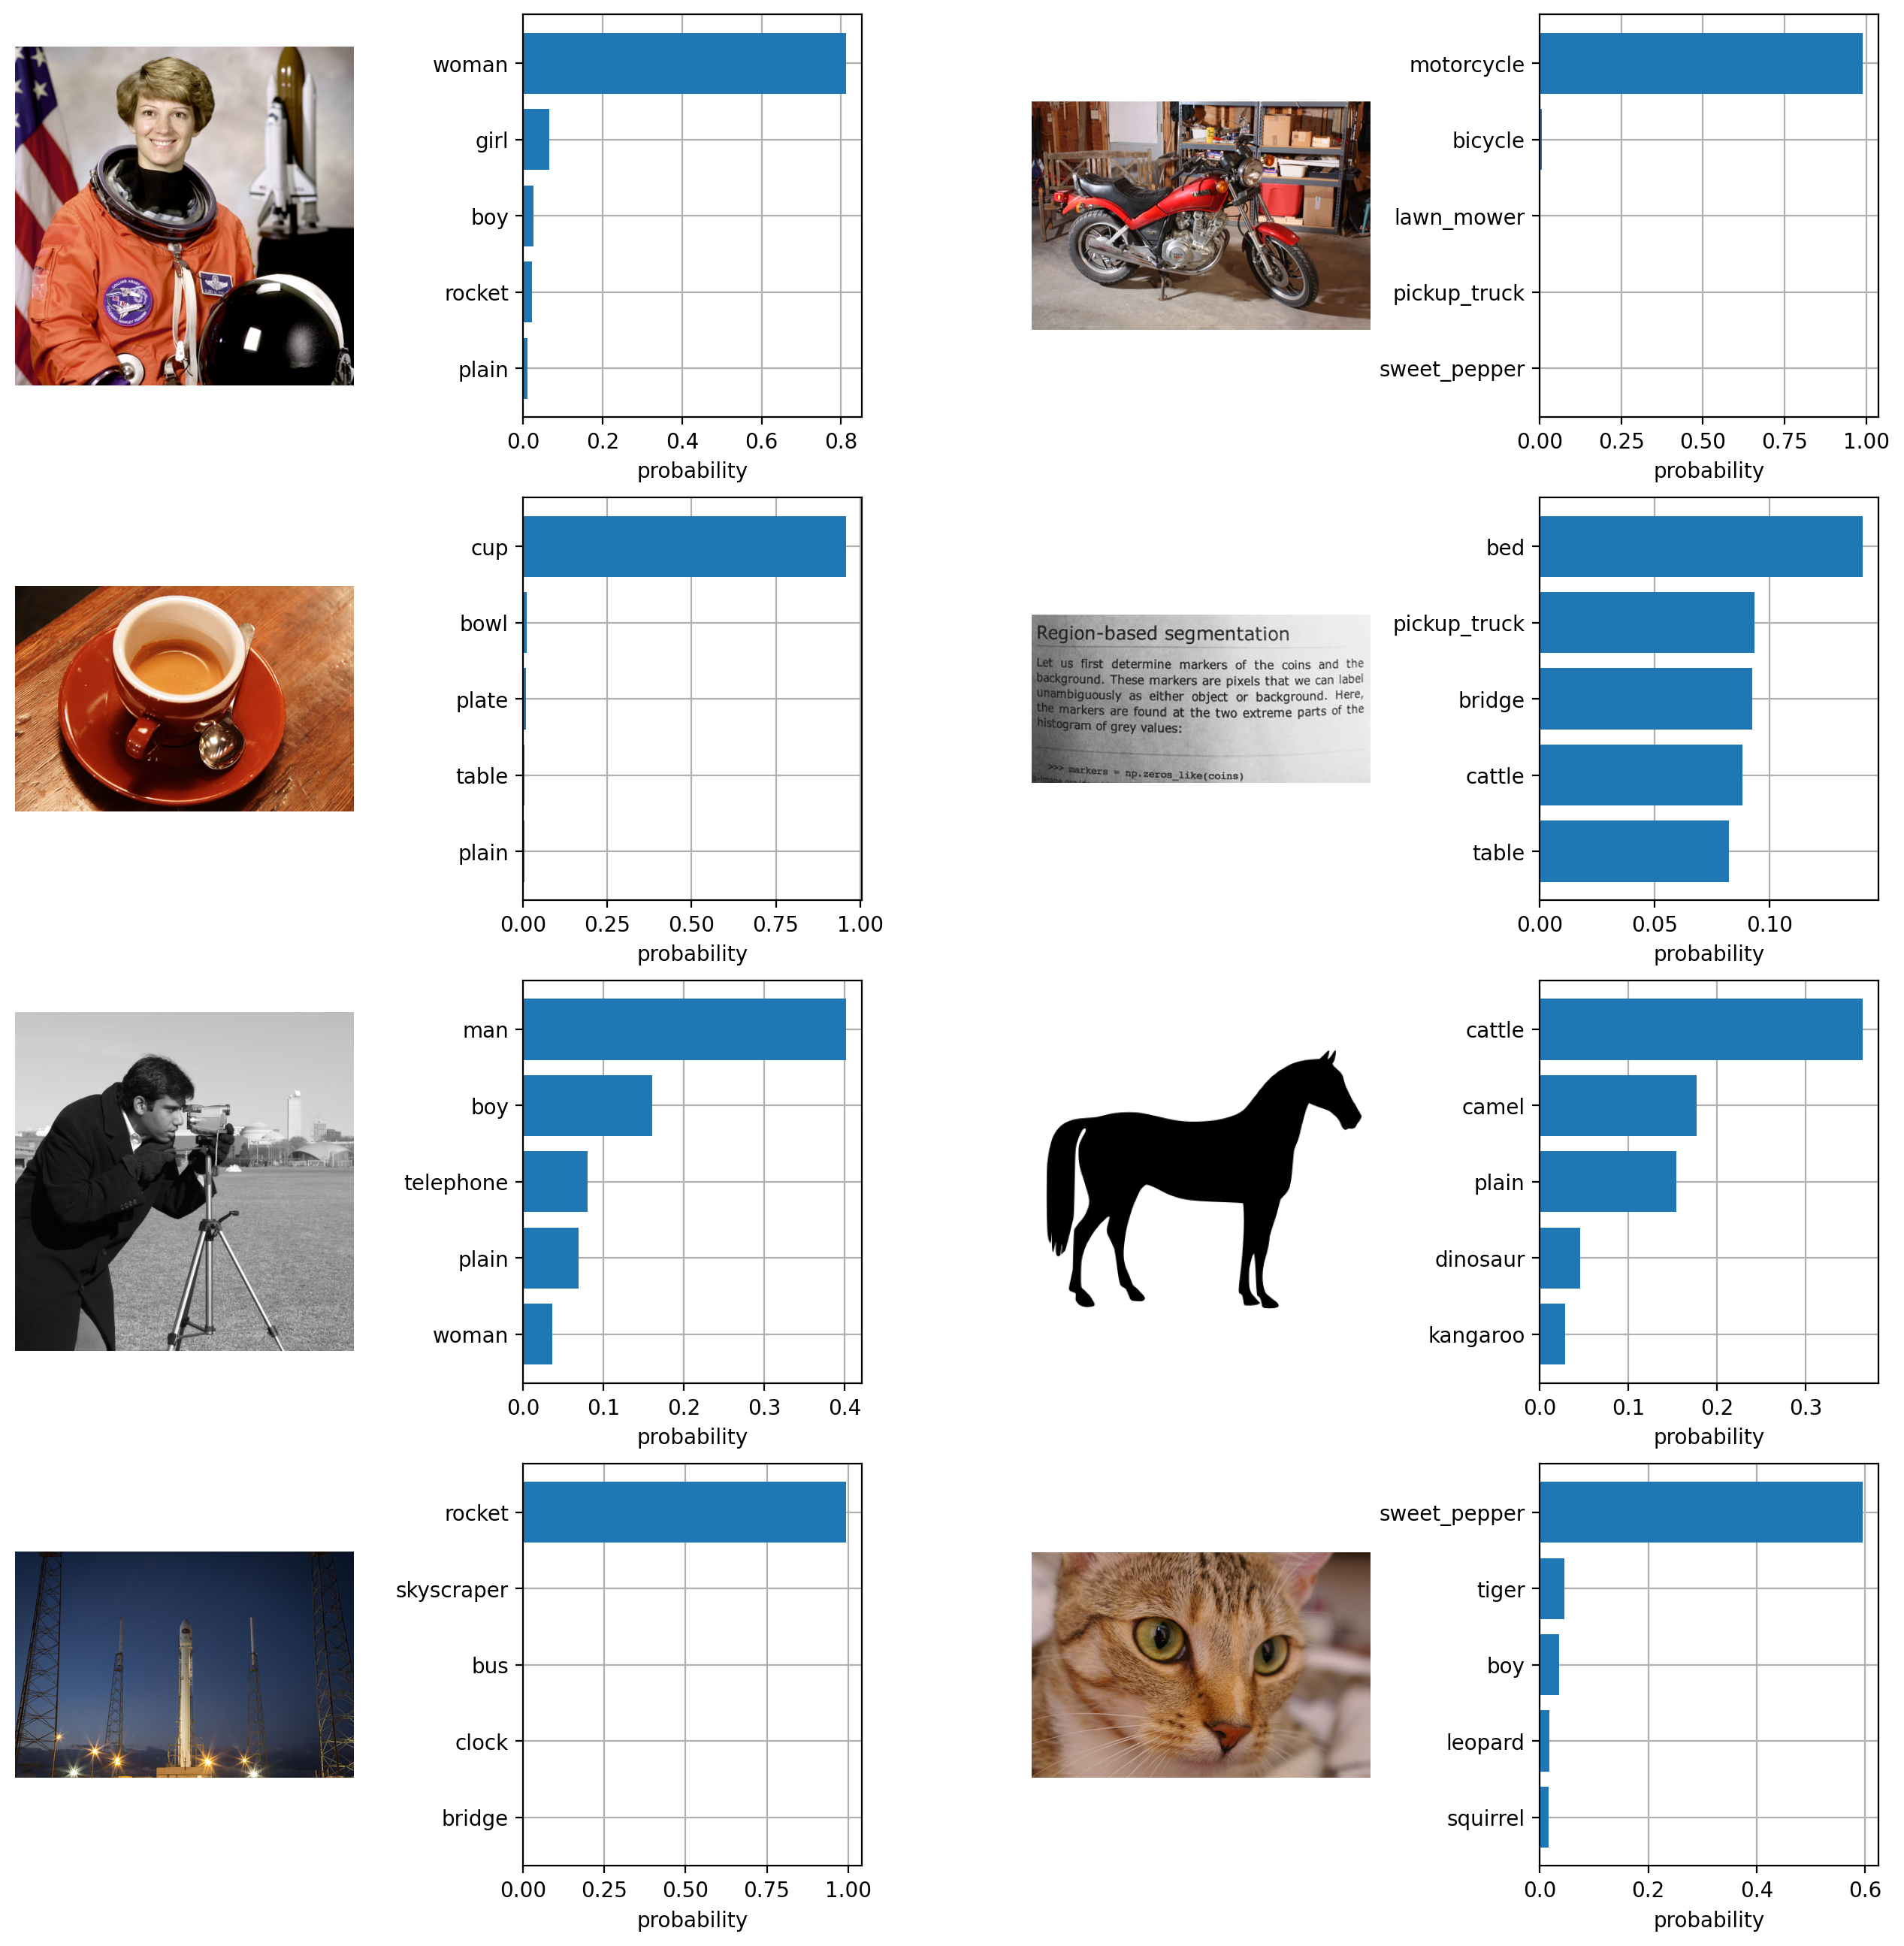

In [36]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()